In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
import pickle
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Функция для расчета WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [4]:
def split_train_oot(data):
    # Находим самую позднюю дату в данных
    latest_date = data['report_date'].max()

    # Вычисляем дату, которая была три месяца назад от самой поздней даты
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # Отбираем строки, где report_date попадает в последние три месяца
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # Теперь заполним NaN значения в столбце 'split_type' значением 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [5]:
# Функция для расчета всех метрик
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [6]:
def shap_gr(name_model, values):# Инициализация SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # Создаем фигуру с регулируемым местом для шкалы
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # Настройки графика
    ax1.set_title("Важность признаков по SHAP значениям", fontsize=14, pad=20)
    ax1.set_xlabel("Влияние на выход модели (SHAP value)", fontsize=12)
    ax1.set_ylabel("Признаки", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [236]:
df = pd.read_csv('для регрессии.csv', parse_dates=['report_date'])
cat = df.copy()
cat=cat[(cat['target_area'].notnull()) & (cat['target_cost'].notnull())].reset_index(drop=True)
cat.shape[0]

7065

In [237]:
cat = split_train_oot(cat)

In [238]:
# Загружаем модель elasticity
with open('model_elasticity_linear_zero.pkl', 'rb') as f:
    model_elasticity = pickle.load(f)
# загрузим фичи
with open('features_model_elasticity_linear_zero.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. Извлечение списков столбцов
numeric_cols = config.get('numeric_columns', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols

In [239]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

,expon_cost__g_building__pc_cost_diff_rel__min__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1M,balance__g_building__rooms_2__structure,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1_4M,expon_cost__g_building__pc_cost_diff_rel__max__1_7M,area__g_building__smt_projected_total_area__fintech_reservation__count,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__min__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__avg__1_7M,...,expon_cost__g_building__pc_cost_diff_rel__avg__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__min__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1_13M,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__3M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__3M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__avg__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__max__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__max__6M
0,0.007264,-0.003000,0.382389,-0.018003,-0.016665,0.007264,0.0,-2.999984e-03,-0.036735,0.005436,...,0.007264,0.034042,-0.020002,-0.039277,-0.020002,0.045003,0.005312,0.020001,0.050001,0.007264
1,0.007264,-0.003000,0.376517,-0.018003,-0.016665,0.007264,0.0,-2.999984e-03,-0.036735,0.005436,...,0.007264,0.034042,-0.020002,-0.039277,-0.020002,0.045003,0.005312,0.020001,0.050001,0.027715
2,-0.050003,-0.050003,0.348872,-0.018003,-0.016665,0.027715,0.0,-2.999984e-03,-0.050003,0.005436,...,0.027715,0.034042,-0.020002,-0.039277,-0.050003,-0.049997,0.005312,0.020001,-0.049997,0.027715
3,-0.050003,0.003000,0.319651,-0.050003,-0.050003,0.030000,0.0,-5.000295e-02,-0.050003,-0.049999,...,-0.049766,-0.049997,-0.050003,-0.050003,-0.050003,0.030006,-0.049999,0.030000,0.005007,0.027715
4,-0.050003,0.030000,0.318048,-0.050003,-0.050003,0.030006,0.0,9.091413e-07,-0.050003,-0.004966,...,-0.009390,0.030000,-0.050003,-0.050003,-0.050003,0.030006,0.010203,0.030006,0.030003,0.030005


In [240]:
# Получить имена признаков, на которых обучалась модель (scikit-learn >= 1.0)
feature_names = model_elasticity.feature_names_in_  

# Убедиться, что в новых данных те же столбцы в том же порядке
X_new = filtered_df[feature_names]  
elasticity_coeff = model_elasticity.predict(X_new)
cat['target_elasticity'] = elasticity_coeff

In [241]:
cat['target_area_base'] = cat['target_area'] - cat['target_elasticity']  * cat['target_cost']

In [242]:
target_ = 'target_area_base'

# Модель

# Тест 1

In [17]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_cost',
    'target_area',
    'target_elasticity',
      target_
]

In [18]:
# Разделяем данные
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# Подготовка признаков
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# Инициализация и обучение модели
model = CatBoostRegressor(
    iterations=2000,
    depth=4,
    learning_rate=0.01,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_base = metrics_df

In [19]:
metrics_df_base

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,158.861330,71163.225731,266.764364,0.305471,0.260125,0.757285,610.710386,571.936532,5938
1,test,198.105314,92691.172485,304.452250,0.614756,0.481831,0.226207,411.151142,506.276605,1127


# Отбор фич

In [20]:
# Подготовка данных
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# Уникальные значения по времени в тренировочной выборке
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# Список для сбора выбранных фич и метрик
features_across_splits = []
metrics_across_splits = []

# Инициализация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Сортируем данные по дате для корректного разбиения
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\n🔹 Сплит {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # Создание Pool объектов
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # Инициализация модели
    model = CatBoostRegressor(
        iterations=1000,
        depth=4,
        learning_rate=0.05,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # Обучение модели
    model.fit(train_pool, eval_set=val_pool)
    
    # Предсказания и метрики
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # Расчет метрик для train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # Расчет метрик для validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # Отбор фичей
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" Отобрано фичей: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame(metrics_across_splits)

# Форматируем даты 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# Переупорядочиваем столбцы
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# Анализ фичей
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n Итоговые устойчивые фичи (встречались >= 2 раз):")
print("Количество:", len(final_features))



🔹 Сплит 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 209.7996672
bestIteration = 66

Shrink model to first 67 iterations.
Feature #3 eliminated
Feature #795 eliminated
Feature #621 eliminated
Feature #889 eliminated
Feature #132 eliminated
Feature #1046 eliminated
Feature #28 eliminated
Feature #25 eliminated
Feature #952 eliminated
Feature #295 eliminated
Feature #743 eliminated
Feature #108 eliminated
Feature #1034 eliminated
Feature #867 eliminated
Feature #513 eliminated
Feature #773 eliminated
Feature #543 eliminated
Feature #630 eliminated
Feature #1042 eliminated
Feature #142 eliminated
Feature #334 eliminated
Feature #165 eliminated
Feature #49 eliminated
Feature #303 eliminated
Feature #819 eliminated
Feature #968 eliminated
Feature #986 eliminated
Feature #518 eliminated
Feature #100 eliminated
Feature #174 eliminated
Feature #136 eliminated
Feature #413 eliminated
Feature #192 eliminated
F

In [21]:
metrics_df_select_features

,split,start_date,end_date,n_samples,mean_target,mean_pred,mae,rmse,mape,wape,r2
0,fold_1_train,2022-03-01,2022-09-01,993,665.591160,584.061509,188.675881,359.218416,0.331006,0.283471,0.630966
1,fold_1_val,2022-09-01,2023-03-01,989,548.699151,537.979779,211.679971,330.973286,0.509885,0.385785,0.478492
2,fold_2_train,2022-03-01,2023-03-01,1982,607.263109,573.049498,88.194636,189.250037,0.162900,0.145233,0.873628
3,fold_2_val,2023-03-01,2023-08-01,989,553.463241,522.491902,183.963224,276.161276,0.421092,0.332386,0.657179
4,fold_3_train,2022-03-01,2023-08-01,2971,589.353964,557.491779,101.295311,199.734335,0.196600,0.171875,0.848754
5,fold_3_val,2023-08-01,2023-12-01,989,728.024112,601.937713,232.579333,389.591076,0.348304,0.319467,0.649596
6,fold_4_train,2022-03-01,2023-12-01,3960,623.986483,542.086016,208.589541,370.035788,0.389001,0.334285,0.557840
7,fold_4_val,2023-12-01,2024-03-01,989,552.966570,598.947618,237.880703,366.336208,0.593367,0.430190,0.477164
8,fold_5_train,2022-03-01,2024-03-01,4949,609.793981,577.893435,116.770120,219.997585,0.221637,0.191491,0.838612
9,fold_5_val,2024-03-01,2024-06-01,989,615.296118,494.198228,211.019345,329.320611,0.352097,0.342956,0.582342


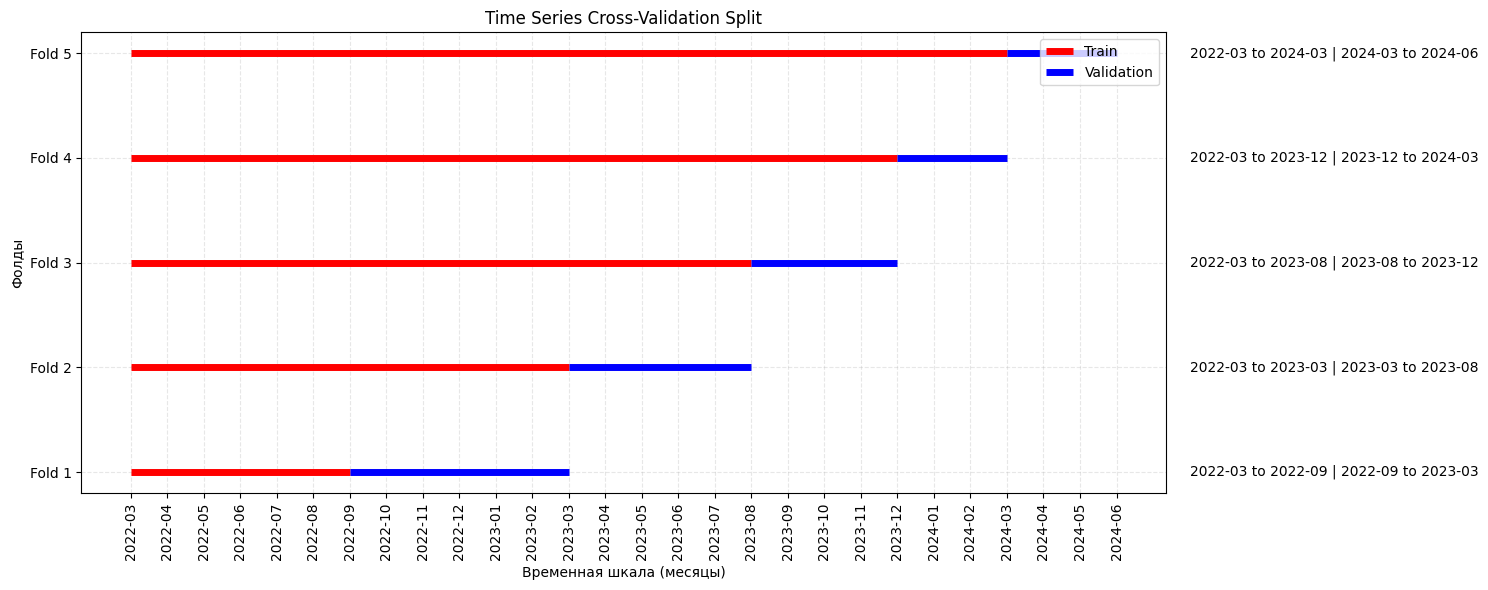

In [22]:
plt.figure(figsize=(15, 6))

# Получаем все уникальные даты
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # Формат YYYY-MM

# Цвета для train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # Находим индексы дат
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # Рисуем линии
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# Настройка графика
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('Временная шкала (месяцы)')
plt.ylabel('Фолды')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# Добавим подписи дат для каждого фолда
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [23]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

,area__g_building__smt_projected_total_area__rooms_0_str_r__count,mortgages__g_building__application__count__6M,price__g_building__rooms_2__sum__1M,sales__g_building__sale_price__rooms_1__sum__12M,sales__g_building__sale_cost__rooms_0__count__1M,area__g_building__smt_projected_total_area__rooms_2_free__sum,sales__g_building__sale_price__sum__6M,area__g_building__smt_projected_total_area__rooms_2_str_r__count,area__g_building__smt_projected_total_area__free__count,expon_cost__g_building__pc_cost_diff__avg__3M,...,expon_cost__g_building__pc_cost_diff__rooms_2__avg__1M,reservations__g_building__smt_projected_total_area__rooms_2__sum__1M,area__g_building__smt_projected_total_area__count,expon_cost__g_building__pc_cost__rooms_2__avg__1M,area__g_building__smt_projected_total_area__free__sum,reservations__g_building__smt_projected_total_area__rooms_1__sum__3M,rosstat_q__g_rd__i40__avg__1_8Q,mortgages__g_building__approved_amount__min__1M,expon_cost__g_building__pc_cost__min__1M,reservations__g_building__min_reservation_date__max
0,0.0,0.0,4.293916e+08,99322260.0,0.0,14610.101,320840615.0,0.0,35.0,1370.000,...,1067.3334,0.0,883.0,207467.20,1509.11,184.965005,105.23781,109601.445,189968.0,899.201588
1,102.0,33.0,2.382018e+09,26425338.0,3.0,4503.900,147893940.0,235.0,278.0,5265.000,...,1067.3334,690.8,883.0,170312.02,12022.20,193.900000,106.00720,98410.875,149109.0,10.000000
2,92.0,180.0,1.946892e+09,104758230.0,10.0,4649.000,724442100.0,172.0,280.0,-8702.604,...,-8531.4730,0.0,883.0,165976.86,12188.90,973.700000,108.30825,0.000,141654.0,41.000000


In [24]:
# Разделение столбцов
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые столбцы:", numeric_cols)
print("Категориальные столбцы:", categorical_cols)

Числовые столбцы: ['area__g_building__smt_projected_total_area__rooms_0_str_r__count', 'mortgages__g_building__application__count__6M', 'price__g_building__rooms_2__sum__1M', 'sales__g_building__sale_price__rooms_1__sum__12M', 'sales__g_building__sale_cost__rooms_0__count__1M', 'area__g_building__smt_projected_total_area__rooms_2_free__sum', 'sales__g_building__sale_price__sum__6M', 'area__g_building__smt_projected_total_area__rooms_2_str_r__count', 'area__g_building__smt_projected_total_area__free__count', 'expon_cost__g_building__pc_cost_diff__avg__3M', 'expon_cost__g_building__pc_cost_diff__avg__1M', 'price__g_building__rooms_0__sum__1M', 'expon_cost__g_building__pc_cost__avg__1M', 'area__g_building__smt_projected_total_area__sum', 'area__g_building__smt_projected_total_area__str_r__count', 'area__g_building__smt_projected_total_area__reservation_end_next_month__count', 'area__g_building__smt_projected_total_area__reserved__sum', 'reservations__g_building__smt_projected_total_area__

In [25]:

# Создаем словарь для YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'id': ['smt_building_addressid'],
    'date' : ['report_date'],
    'target' : [target_]
}

# Записываем в YAML-файл
with open('features_model_final_area.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [243]:
# загрузим фичи
with open('features_model_final_area.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. Извлечение списков столбцов
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [244]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

,area__g_building__smt_projected_total_area__rooms_0_str_r__count,mortgages__g_building__application__count__6M,price__g_building__rooms_2__sum__1M,sales__g_building__sale_price__rooms_1__sum__12M,sales__g_building__sale_cost__rooms_0__count__1M,area__g_building__smt_projected_total_area__rooms_2_free__sum,sales__g_building__sale_price__sum__6M,area__g_building__smt_projected_total_area__rooms_2_str_r__count,area__g_building__smt_projected_total_area__free__count,expon_cost__g_building__pc_cost_diff__avg__3M,...,reservations__g_building__smt_projected_total_area__rooms_2__sum__1M,area__g_building__smt_projected_total_area__count,expon_cost__g_building__pc_cost__rooms_2__avg__1M,area__g_building__smt_projected_total_area__free__sum,reservations__g_building__smt_projected_total_area__rooms_1__sum__3M,rosstat_q__g_rd__i40__avg__1_8Q,target_area_base,mortgages__g_building__approved_amount__min__1M,expon_cost__g_building__pc_cost__min__1M,reservations__g_building__min_reservation_date__max
0,0.0,0.0,4.293916e+08,99322260.0,0.0,14610.1010,3.208406e+08,0.0,35.0,1370.0000,...,0.0,883.0,207467.20,1509.11,184.965005,105.237810,960.380604,109601.445,189968.0,899.201588
1,102.0,33.0,2.382018e+09,26425338.0,3.0,4503.9000,1.478939e+08,235.0,278.0,5265.0000,...,690.8,883.0,170312.02,12022.20,193.900000,106.007200,3696.415978,98410.875,149109.0,10.000000
2,92.0,180.0,1.946892e+09,104758230.0,10.0,4649.0000,7.244421e+08,172.0,280.0,-8702.6040,...,0.0,883.0,165976.86,12188.90,973.700000,108.308250,3679.792631,0.000,141654.0,41.000000
3,78.0,348.0,1.580494e+09,138470860.0,0.0,4585.3000,1.311990e+09,118.0,273.0,-1670.6924,...,0.0,883.0,165093.98,11946.90,1208.900000,105.286990,1508.952539,53475.934,141654.0,71.000000
4,69.0,410.0,1.527488e+09,173542350.0,9.0,4611.3003,1.543108e+09,106.0,275.0,-1429.4852,...,700.5,883.0,168027.58,12099.90,1115.600000,105.277084,1450.710778,66860.460,142079.0,102.000000


In [245]:
filtered_df = split_train_oot(filtered_df)

# Модель 2 на выбранных фичах

In [195]:
# Разделим данные на тренировочные и тестовые
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# Выберите признаки (features) и целевую переменную (target)
# Допустим, у вас есть столбец 'target', который нужно предсказать
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 'report_date',
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',
                         target_])  
y_test = test_data[target_]

# Инициализируем модель 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=4,         
                    learning_rate=0.01,  # Уменьшаем learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=3,   
                    random_strength=1,
                    early_stopping_rounds=100,  # Ранняя остановка
                    verbose=200,
                    grow_policy='Lossguide'  # Альтернативная стратегия роста
                )
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)

# Делаем предсказания 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_with_select_features = metrics_df

0:	learn: 358.3624072	total: 3.65ms	remaining: 7.31s
200:	learn: 216.1664985	total: 530ms	remaining: 4.75s
400:	learn: 190.5644104	total: 1.14s	remaining: 4.53s
600:	learn: 178.7423591	total: 1.66s	remaining: 3.87s
800:	learn: 171.0430263	total: 2.2s	remaining: 3.29s
1000:	learn: 164.6419993	total: 2.71s	remaining: 2.71s
1200:	learn: 158.9740309	total: 3.25s	remaining: 2.17s
1400:	learn: 154.2078076	total: 3.79s	remaining: 1.62s
1600:	learn: 149.9183375	total: 4.31s	remaining: 1.07s
1800:	learn: 146.4059584	total: 4.82s	remaining: 533ms
1999:	learn: 143.4453048	total: 5.33s	remaining: 0us


In [196]:
metrics_df_with_select_features

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,143.445306,58626.184743,242.128447,0.280555,0.234883,0.800045,610.710386,573.157772,5938
1,test,202.463287,90406.723016,300.677108,0.642081,0.492430,0.245278,411.151142,527.884178,1127


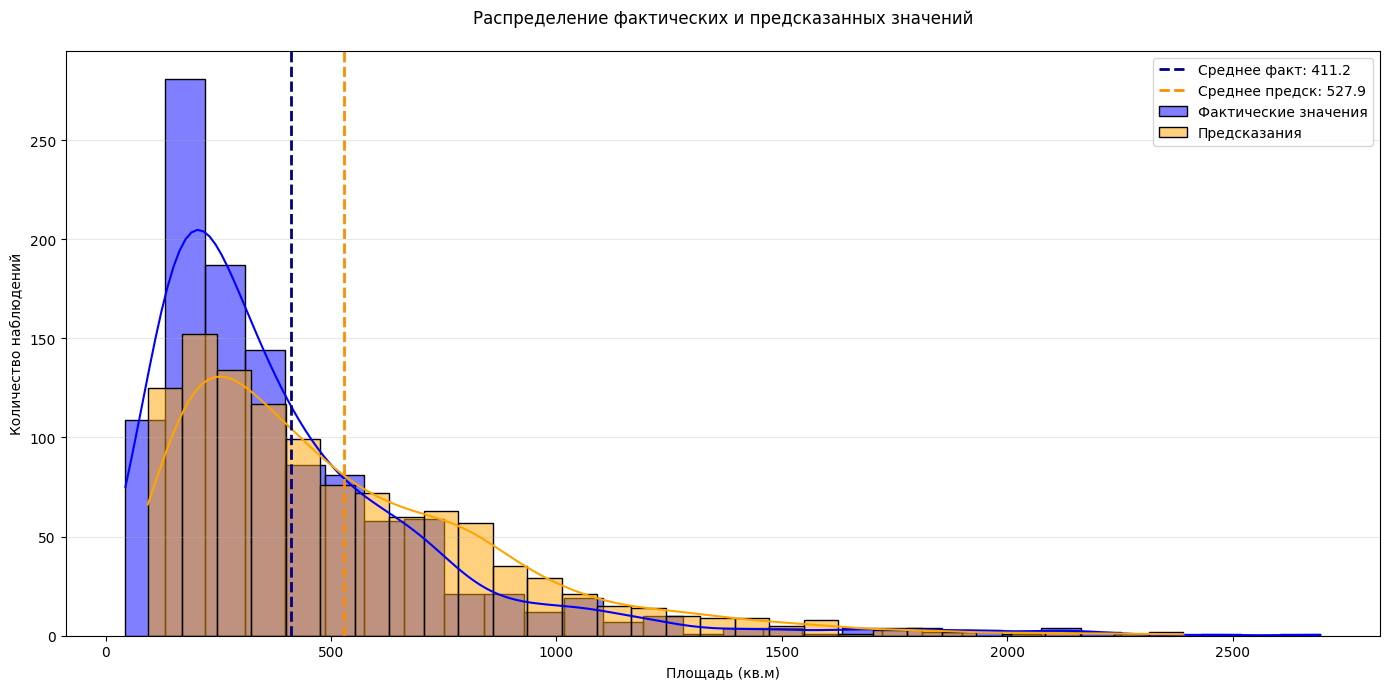

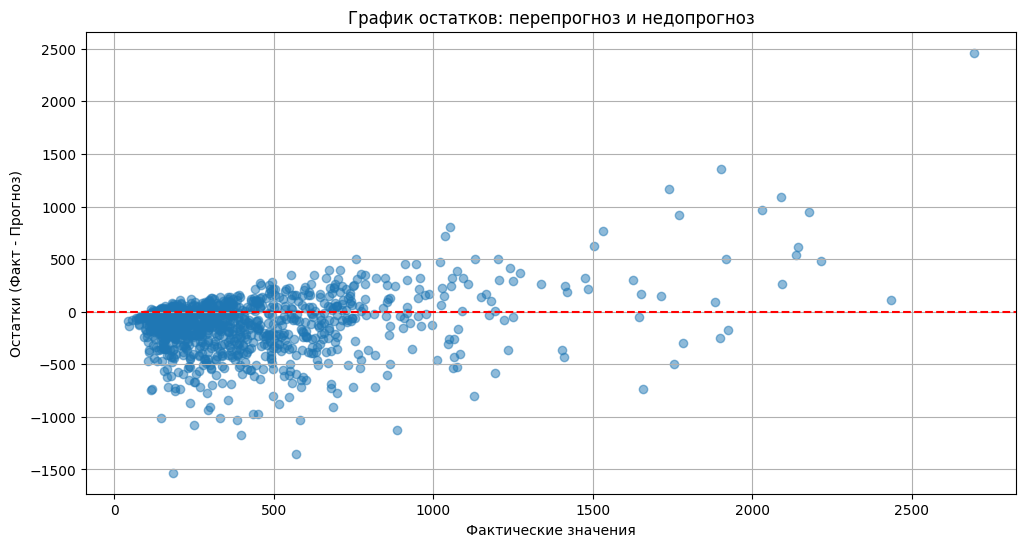

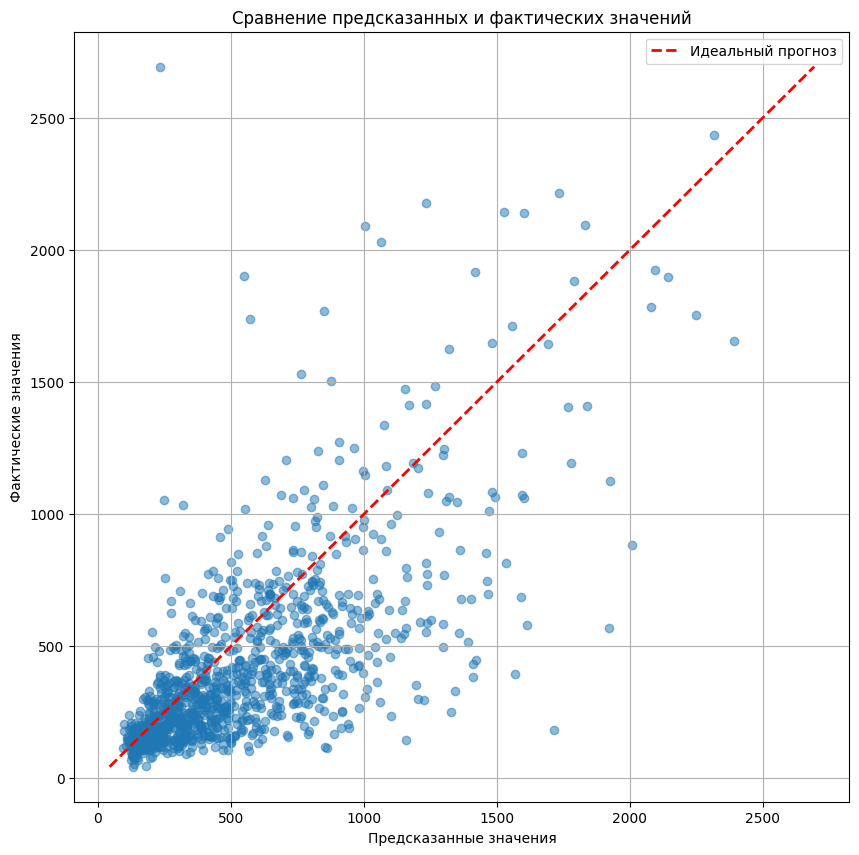

In [31]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()

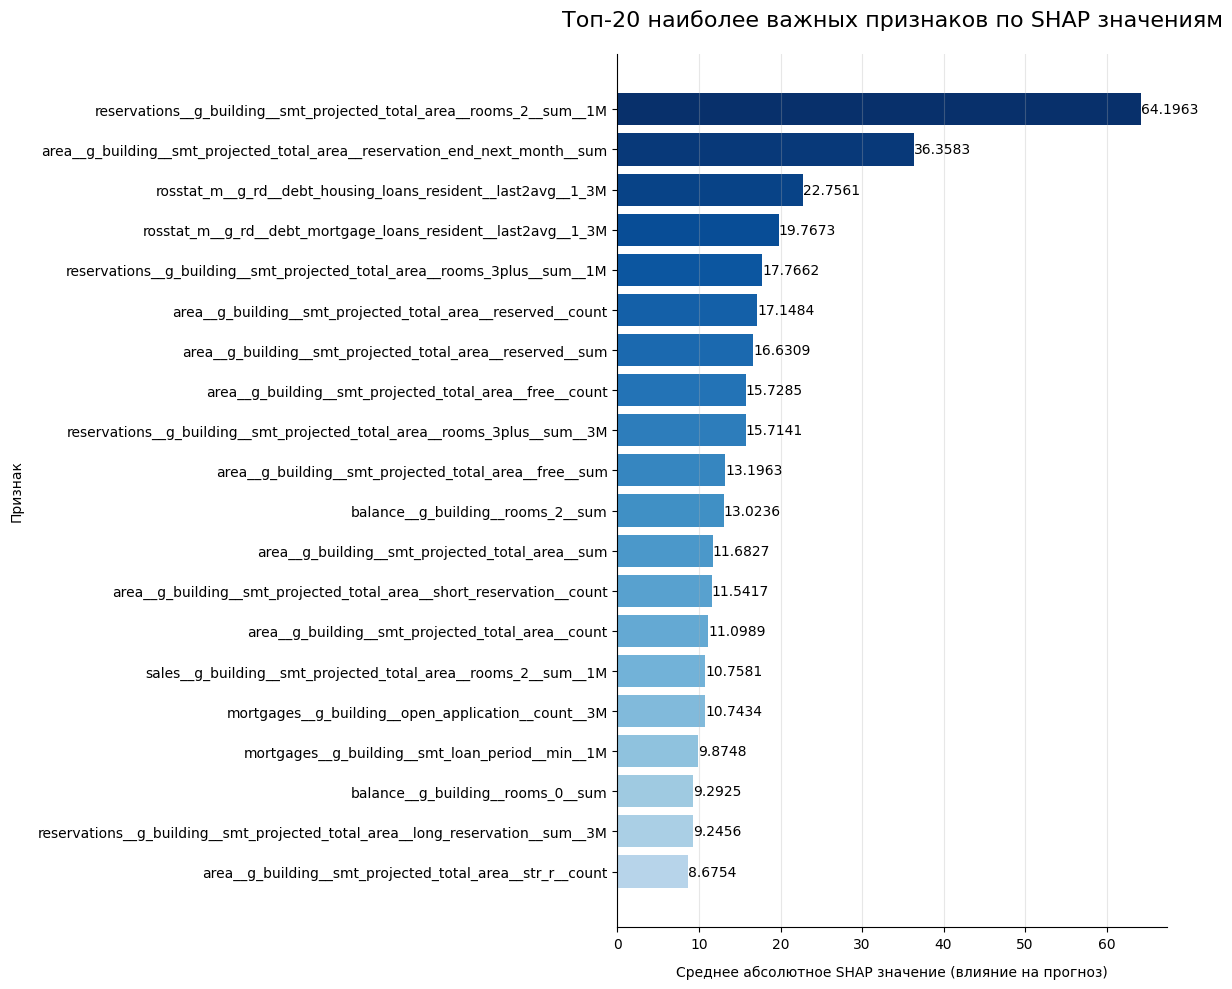

In [32]:
# Инициализация и расчет SHAP значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Создаем DataFrame с важностью фич
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# Стилизация графика
plt.figure(figsize=(12, 10))

# Горизонтальный bar plot с цветовой градацией
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# Добавляем значения на график
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# Настройки внешнего вида
plt.title('Топ-20 наиболее важных признаков по SHAP значениям', pad=20, fontsize=16)
plt.xlabel('Среднее абсолютное SHAP значение (влияние на прогноз)', labelpad=10)
plt.ylabel('Признак', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


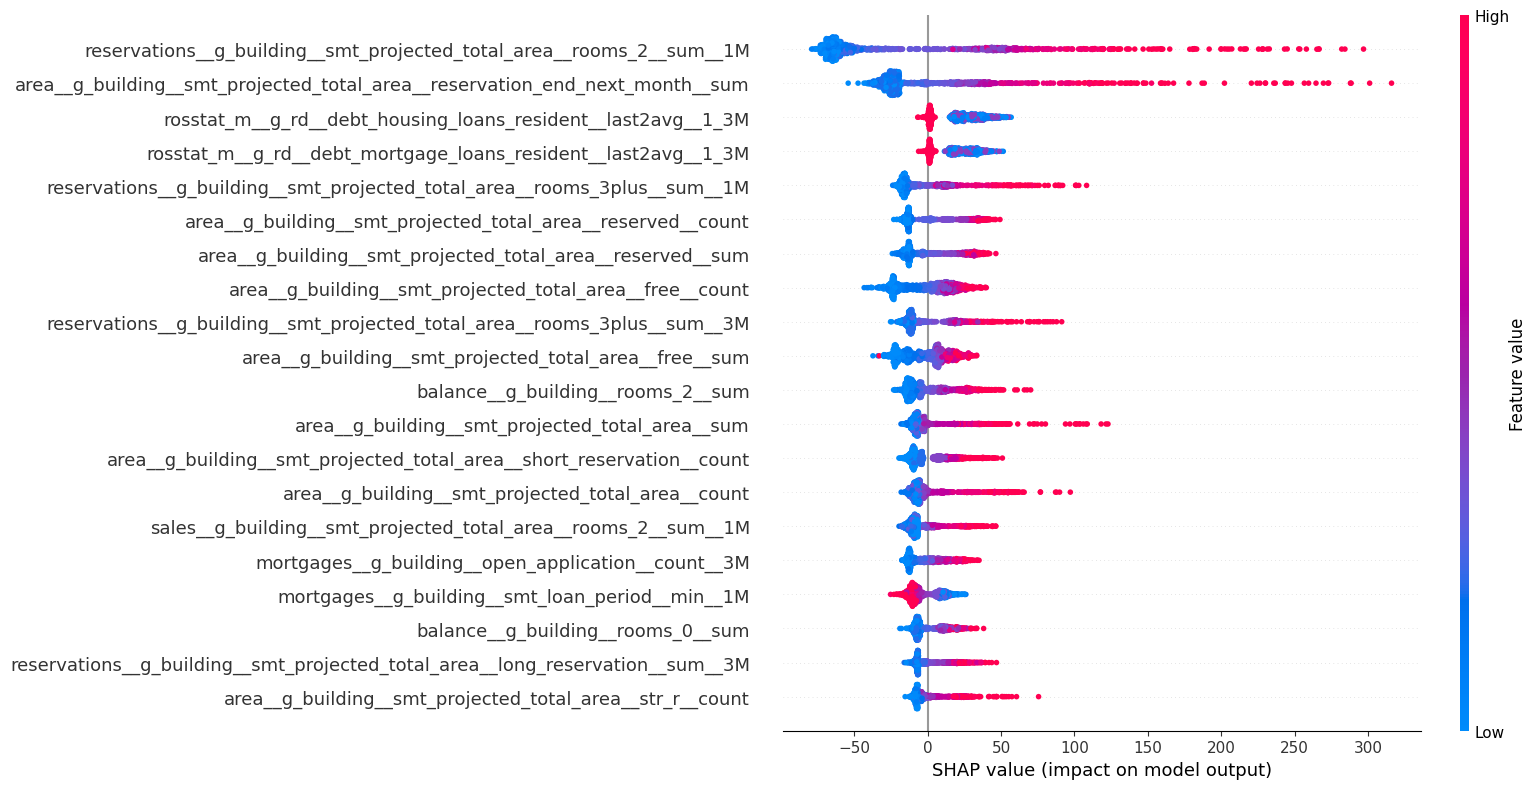

In [33]:
shap_gr(model, X_test)

# OPTUNA

In [246]:
# Разделяем данные
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date', target_])
y_test = test_data[target_]

# Делим часть train на train/valid для Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# Для CatBoost нужно указывать cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# Улучшенная оптимизация через Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # Добавляем параметры в зависимости от типа бутстрапа
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Улучшенный запуск Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=30)  

print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# Удаляем параметры, которые не нужны в финальной модели
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# Делаем предсказания 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_optuna = metrics_df

[I 2025-05-21 23:38:21,588] A new study created in memory with name: no-name-6ab6650d-ead3-4689-b8fb-7463cd276558
[I 2025-05-21 23:38:24,384] Trial 0 finished with value: 175.59300836795762 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 175.59300836795762.
[I 2025-05-21 23:38:26,346] Trial 1 finished with value: 188.36905735934008 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 175.59300836795762.
[I 2025-05-21 23:38:28,827] Trial 2

Лучшие параметры:
iterations: 2179
depth: 7
learning_rate: 0.013450549446761025
l2_leaf_reg: 7.832430217107163
random_strength: 1.813342615712527
border_count: 111
min_data_in_leaf: 32
grow_policy: SymmetricTree
bootstrap_type: MVS
0:	learn: 357.5634002	total: 2.62ms	remaining: 2.61s
100:	learn: 227.9405471	total: 298ms	remaining: 2.65s
200:	learn: 194.5441880	total: 565ms	remaining: 2.24s
300:	learn: 179.3671204	total: 817ms	remaining: 1.9s
400:	learn: 169.1737770	total: 1.08s	remaining: 1.61s
500:	learn: 161.7499904	total: 1.33s	remaining: 1.32s
600:	learn: 155.3170963	total: 1.58s	remaining: 1.05s
700:	learn: 149.0294015	total: 1.83s	remaining: 780ms
800:	learn: 143.2598018	total: 2.09s	remaining: 519ms
900:	learn: 138.0612825	total: 2.35s	remaining: 258ms
999:	learn: 133.2751690	total: 2.6s	remaining: 0us


In [198]:
metrics_df_optuna

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,133.275170,47719.006404,218.446805,0.269066,0.218230,0.837246,610.710386,576.607153,5938
1,test,202.641246,90795.404984,301.322759,0.642815,0.492863,0.242033,411.151142,527.815085,1127


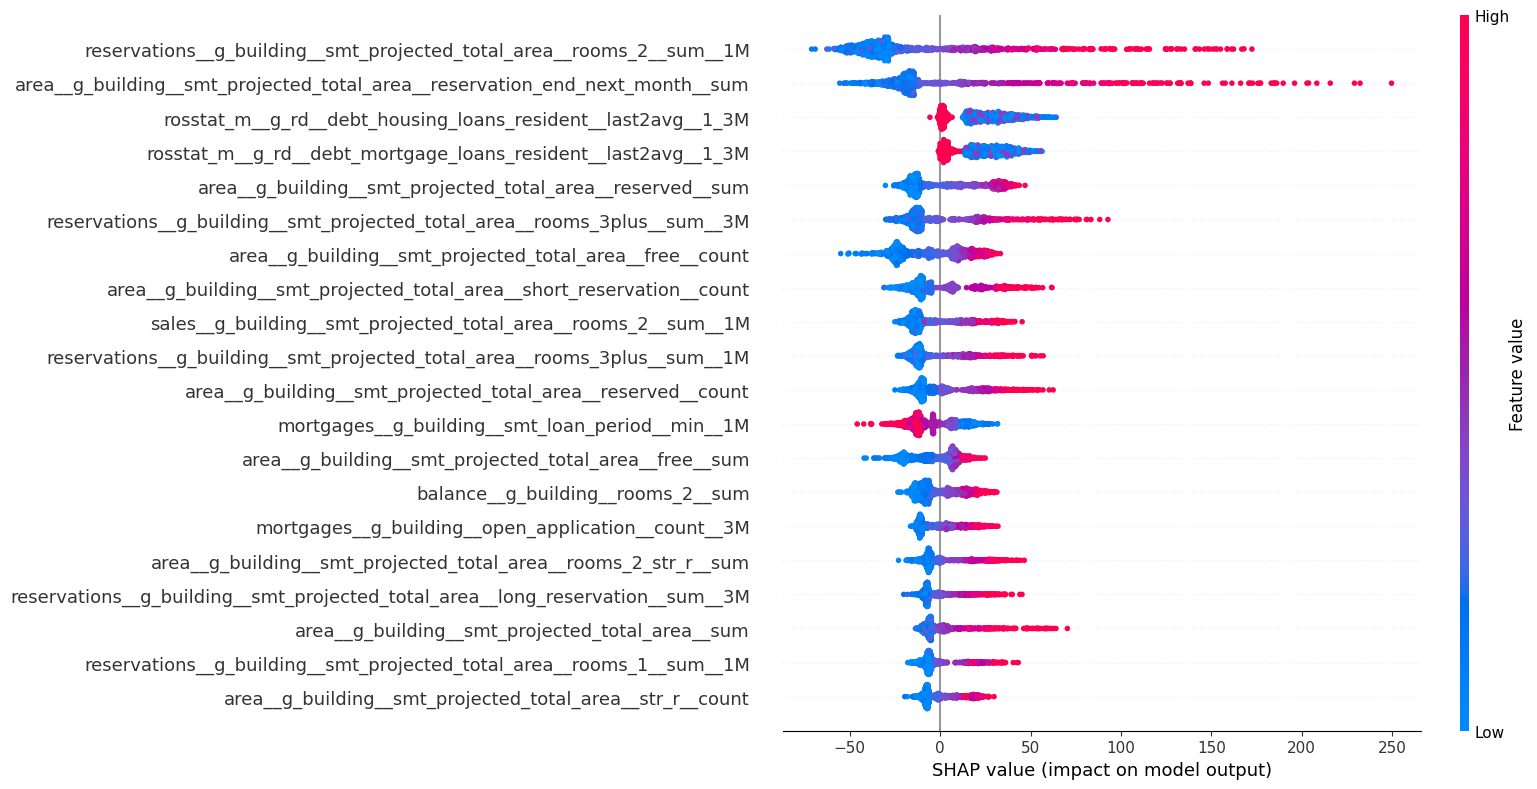

In [36]:
shap_gr(final_model, X_test)

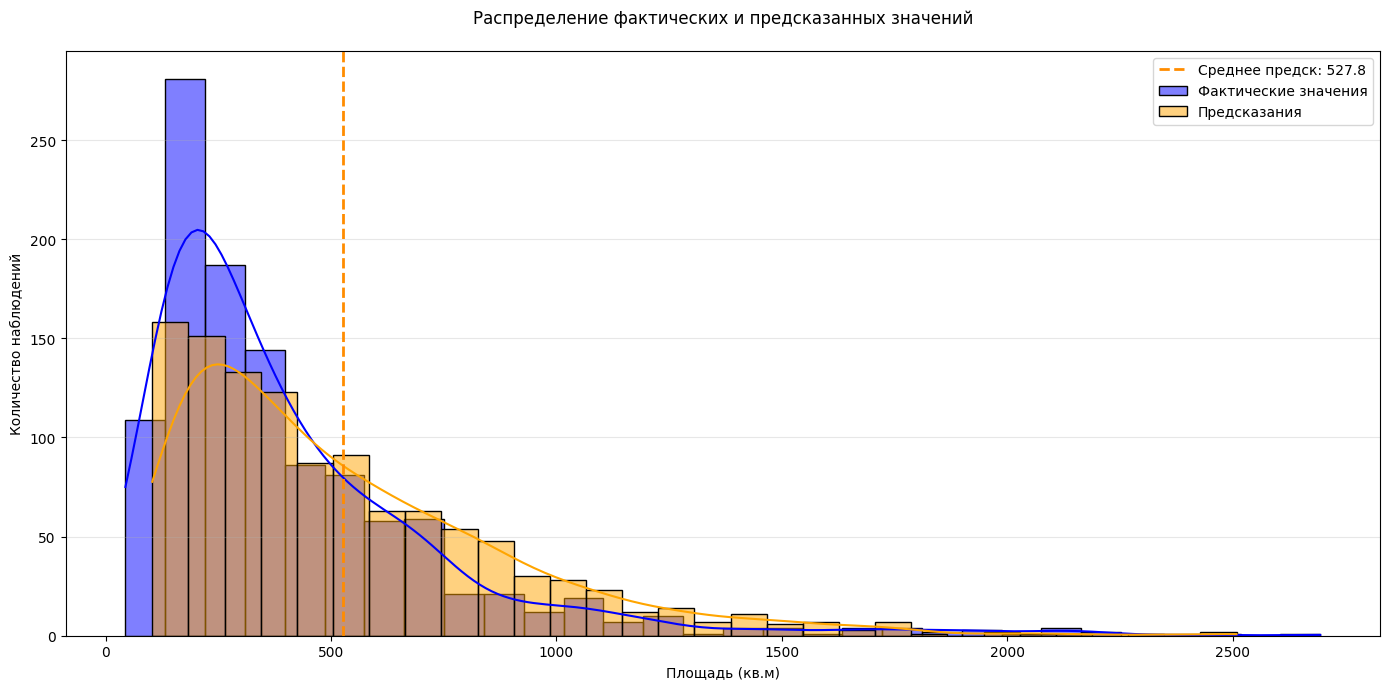

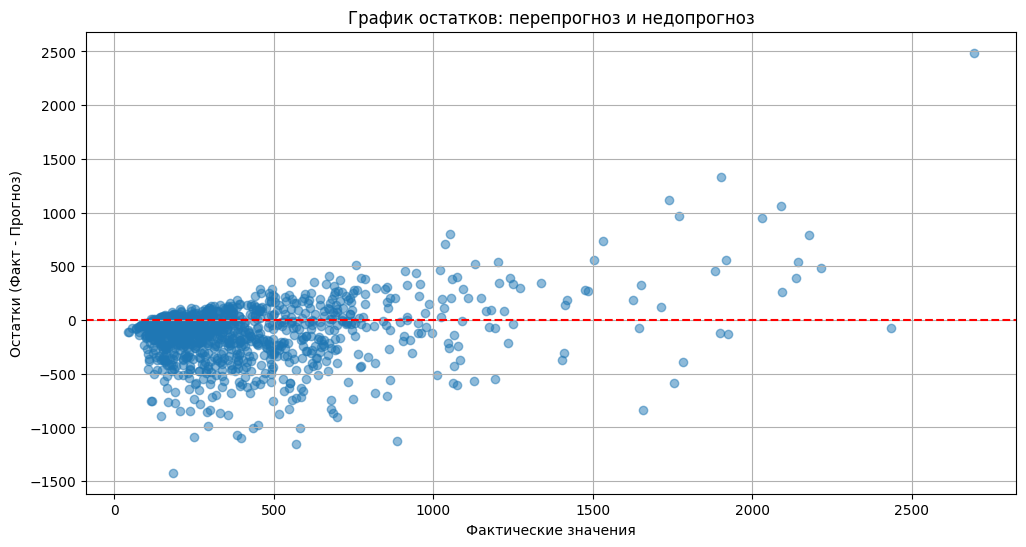

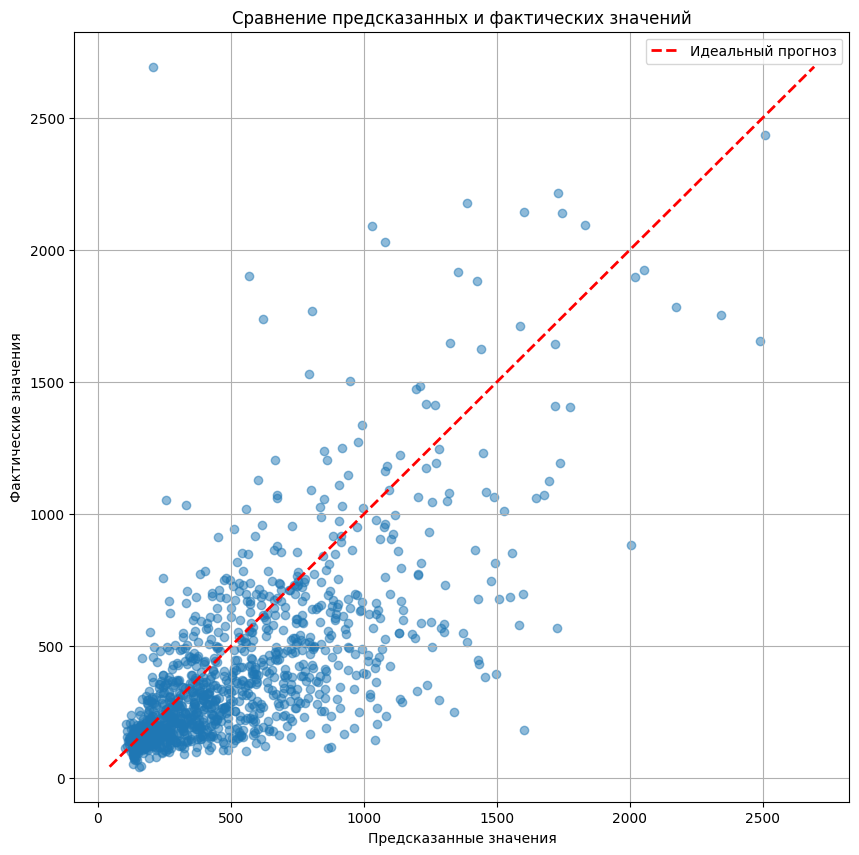

In [37]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
# plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()


In [38]:
metrics_df_base.insert(0, 'stage', 'Базовая модель')
metrics_df_with_select_features.insert(0, 'stage', 'Модель с отбором признаков')
metrics_df_optuna.insert(0, 'stage', 'Оптимизированная модель (Optuna)')

In [39]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

,stage,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,Базовая модель,train,158.861330,71163.225731,266.764364,0.305471,0.260125,0.757285,610.710386,571.936532,5938
1,Базовая модель,test,198.105314,92691.172485,304.452250,0.614756,0.481831,0.226207,411.151142,506.276605,1127
2,Модель с отбором признаков,train,143.445306,58626.184743,242.128447,0.280555,0.234883,0.800045,610.710386,573.157772,5938
3,Модель с отбором признаков,test,202.463287,90406.723016,300.677108,0.642081,0.492430,0.245278,411.151142,527.884178,1127
4,Оптимизированная модель (Optuna),train,133.275170,47719.006404,218.446805,0.269066,0.218230,0.837246,610.710386,576.607153,5938
5,Оптимизированная модель (Optuna),test,202.641246,90795.404984,301.322759,0.642815,0.492863,0.242033,411.151142,527.815085,1127


In [40]:
# Сохраняем модель
with open('model_final.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Графики

In [43]:
base = test_pred
coeff = cat[cat['split_type']=='oot']['target_elasticity']
cost = cat[cat['split_type']=='oot']['target_cost']

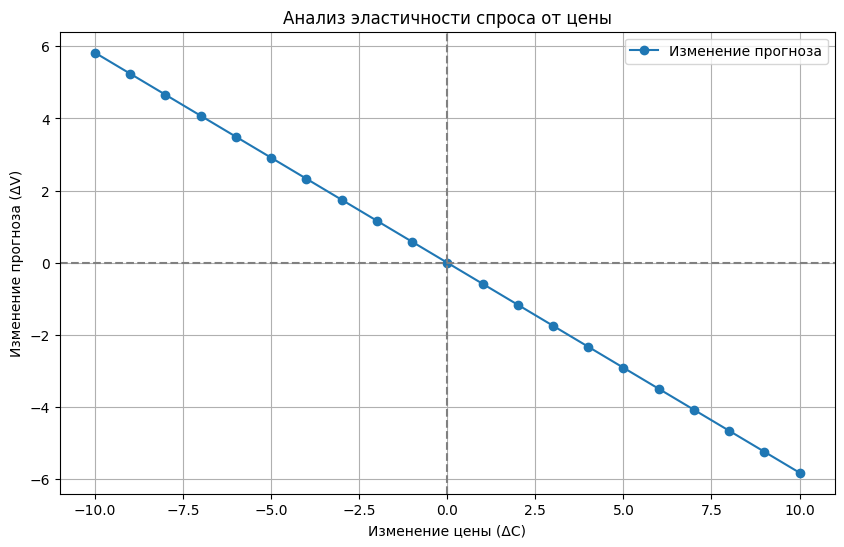

In [45]:
# 1. Базовый прогноз (без учета изменений цены)
V_pred_0 = base+coeff * cost

# 2. Подготовка данных для анализа
results = []

for alpha in np.arange(-0.1, 0.101, 0.01):
    # Модифицируем отклонение цены
    modified_pred = base +coeff * (cost * (1+alpha))
    # Рассчитываем ΔV и ΔC
    delta_V = ((modified_pred - V_pred_0) / V_pred_0)
    delta_C = alpha
    
    # Сохраняем результаты
    results.append({
        'alpha': alpha,
        'delta_C': delta_C*100,
        'delta_V_mean': np.mean(delta_V*100),
        'delta_V': delta_V
    })

# 3. Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

# График
plt.figure(figsize=(10, 6))
plt.plot(results_df['delta_C'], results_df['delta_V_mean'], 'o-', label='Изменение прогноза')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Изменение цены (ΔC)')
plt.ylabel('Изменение прогноза (ΔV)')
plt.title('Анализ эластичности спроса от цены')
plt.legend()
plt.grid(True)
plt.show()

In [247]:
drop_cols = [
'split_type', 'smt_building_addressid', 'report_date','target_area_base','target_cost','elast_predicted'
]

In [248]:
plot_df = filtered_df.copy()

In [249]:
final_pred =final_model.predict(filtered_df.drop(columns=['smt_building_addressid', 'split_type', 'report_date', target_ ]))
plot_df['target_cost'] = cat['target_cost']
plot_df['elast_predicted'] = elasticity_coeff

In [250]:
plot_df['final_area'] = final_pred + plot_df['elast_predicted'] *plot_df['target_cost'] 

In [251]:
plot_df['target_area'] = cat['target_area'] 

In [279]:
for_lin = plot_df.groupby(['report_date', 'split_type'], as_index=False).agg({'target_area':'mean',
                                                                    'final_area':'mean'
                                                                    }).rename(columns={'target_area':'mean_target',
                                                                               'final_area':'mean_predict'})
for_lin

,report_date,split_type,mean_target,mean_predict
0,2022-03-01,train,665.991606,594.734157
1,2022-04-01,train,499.400473,508.231918
2,2022-05-01,train,557.417557,530.992402
3,2022-06-01,train,532.989730,496.814375
4,2022-07-01,train,629.758672,564.247765
5,2022-08-01,train,707.602533,638.159473
6,2022-09-01,train,502.754839,561.032324
7,2022-10-01,train,465.177823,469.510727
8,2022-11-01,train,526.758324,463.760319
9,2022-12-01,train,550.963390,476.060861


In [299]:
# Для целевой переменной
for_lin['mean_target_norm'] = (for_lin['mean_target'] - for_lin['mean_target'].min()) / \
                              (for_lin['mean_target'].max() - for_lin['mean_target'].min())

# Для предсказаний
for_lin['mean_predict_norm'] = (for_lin['mean_predict'] - for_lin['mean_predict'].min()) / \
                               (for_lin['mean_predict'].max() - for_lin['mean_predict'].min())

# Проверка
print("Диапазон target после нормализации:", 
      for_lin['mean_target_norm'].min(), for_lin['mean_target_norm'].max())
print("Диапазон predict после нормализации:", 
      for_lin['mean_predict_norm'].min(), for_lin['mean_predict_norm'].max())

Диапазон target после нормализации: 0.0 1.0
Диапазон predict после нормализации: 0.0 1.0


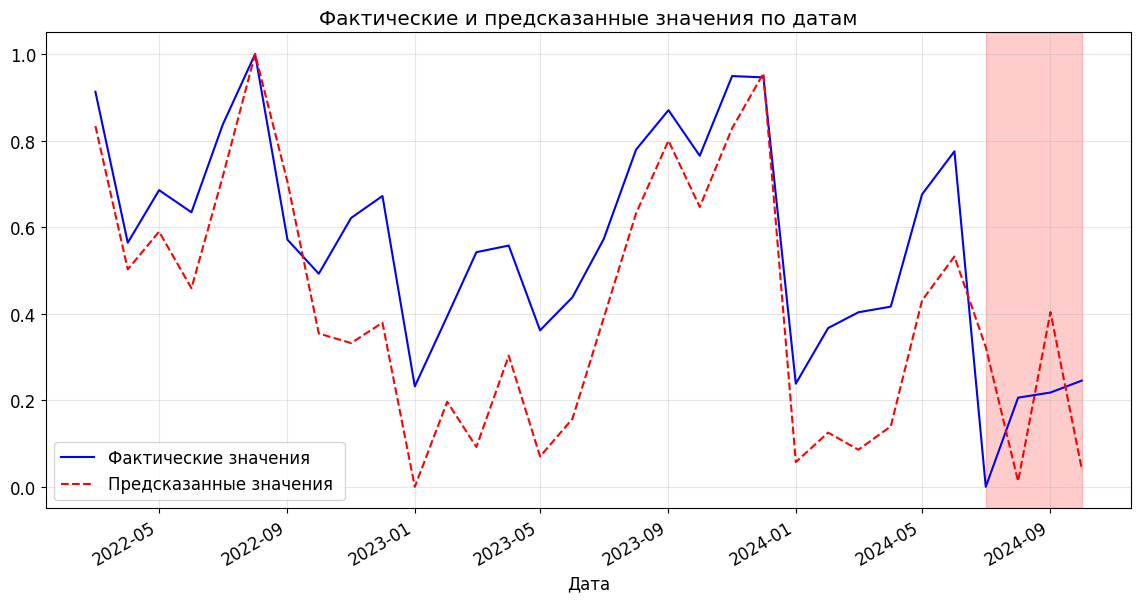

In [305]:
# Нормализация
for_lin['mean_target_norm'] = (for_lin['mean_target'] - for_lin['mean_target'].min()) / \
                              (for_lin['mean_target'].max() - for_lin['mean_target'].min())
for_lin['mean_predict_norm'] = (for_lin['mean_predict'] - for_lin['mean_predict'].min()) / \
                               (for_lin['mean_predict'].max() - for_lin['mean_predict'].min())

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(for_lin['report_date'], for_lin['mean_target_norm'], 
         color='blue', label='Фактические значения')
plt.plot(for_lin['report_date'], for_lin['mean_predict_norm'], 
         color='red', linestyle='--', label='Предсказанные значения ')

# Выделение тестового периода
test_dates = for_lin[for_lin['split_type'] == 'oot']['report_date']
if not test_dates.empty:
    plt.axvspan(test_dates.min(), test_dates.max(), color='red', alpha=0.2)

plt.title('Фактические и предсказанные значения по датам')
plt.xlabel('Дата')
plt.ylim(-0.05, 1.05)  # Добавляем небольшие отступы
plt.grid(True, alpha=0.3)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

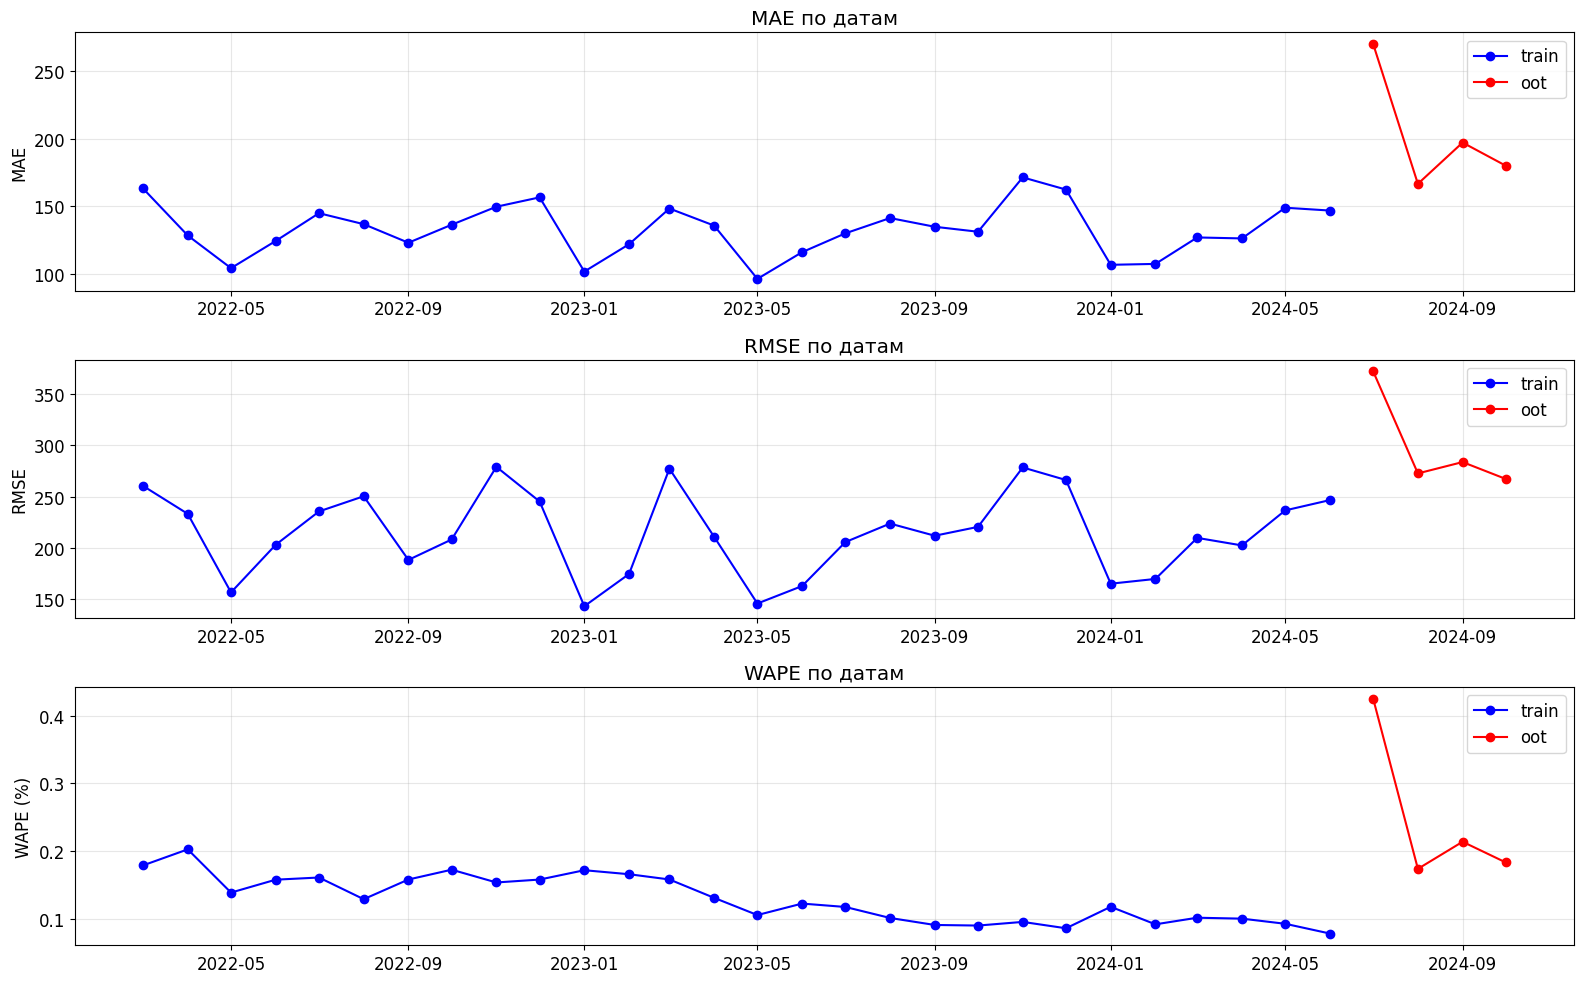

In [285]:
# Рассчитываем ошибки
plot_df['abs_error'] = np.abs(plot_df['target_area'] - plot_df['final_area'])
plot_df['squared_error'] = (plot_df['target_area'] - plot_df['final_area'])**2

# Группируем по датам и split_type
metrics = plot_df.groupby(['report_date', 'split_type']).agg({
    'abs_error': 'mean',
    'squared_error': lambda x: np.sqrt(x.mean()),
    'target_area': 'sum'
}).reset_index()
metrics.rename(columns={'abs_error': 'MAE', 'squared_error': 'RMSE'}, inplace=True)
metrics['WAPE'] = metrics['MAE'] / metrics['target_area'] * 100

# Построение
plt.figure(figsize=(16, 10))

for i, metric in enumerate(['MAE', 'RMSE', 'WAPE'], 1):
    plt.subplot(3, 1, i)
    for split, color in zip(['train', 'oot'], ['blue', 'red']):
        subset = metrics[metrics['split_type'] == split]
        plt.plot(subset['report_date'], subset[metric], 'o-', color=color, label=split)
    
    plt.title(f'{metric} по датам')
    plt.ylabel(metric + (' (%)' if metric == 'WAPE' else ''))
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

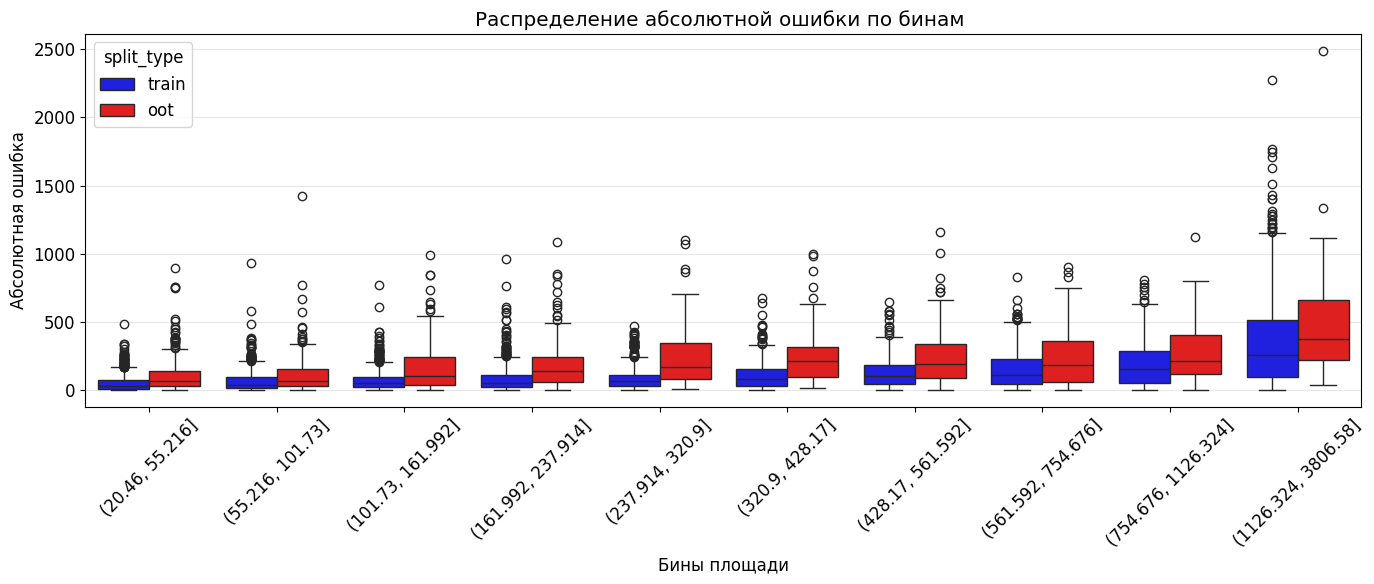

In [293]:
# 1. Создаем бины по квантилям
bins = plot_df['target_area'].quantile(np.linspace(0, 1, 11)).unique()
plot_df['area_bin'] = pd.cut(plot_df['target_area'], bins=bins)

# 2. Фильтруем редкие бины
min_oot = 3  # Минимальное количество OOT-наблюдений
valid_bins = plot_df[plot_df['split_type'] == 'oot'].groupby('area_bin').filter(lambda x: len(x) >= min_oot)['area_bin'].unique()
filtered_df = plot_df[plot_df['area_bin'].isin(valid_bins)]

# 3. Строим график
plt.figure(figsize=(14, 6))
sns.boxplot(
    x='area_bin',
    y='abs_error',
    hue='split_type',
    data=filtered_df,
    palette={'train': 'blue', 'val': 'green', 'oot': 'red'},
    order=sorted(valid_bins)
)

plt.title('Распределение абсолютной ошибки по бинам ')
plt.xlabel('Бины площади')
plt.ylabel('Абсолютная ошибка')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()